<a href="https://colab.research.google.com/github/Mikful/fastai_audio-1/blob/master/Getting_Started-Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Update Fast AI**

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# Setup Fast.ai Audio

**Download Github repo**

This only needs to be done once (I think - may need to check when reopening that repo is there)

In [2]:
#Setup without google drive access
  # Create folder for repo
  # Change directory to new folder
  # Name data folder
  # Clone github repo into folder
  
#!mkdir /fastai_audio
%cd /content
data_folder = 'data'
!git clone https://github.com/mogwai/fastai_audio.git 


/content
Cloning into 'fastai_audio'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 1500 (delta 33), reused 136 (delta 23), pack-reused 1342
Receiving objects: 100% (1500/1500), 177.10 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (853/853), done.


In [3]:
 # Change directory to new fastai_audio folder
  # Pull repo
  # Install repo dependencies

%cd /content/fastai_audio
!git pull
!bash install.sh 

/content/fastai_audio
Already up to date.
     |████████████████████████████████| 81kB 6.7MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=9a88c699674e62b2888cf61b7f0331dfde9f623a7f79393d0a418649b0ed8b12
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packag

**Now import newly installed PyTorch Audio!:**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import sys
import csv
import shutil
from pathlib import Path
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

In [0]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

# FastAI Audio

This notebook will show you the fastest way to get started with FastAI audio by demonstrating only the most essential functionality. In the `examples` folder, we have included a number of other notebooks that show more features, and teach you about audio in general. If you'd like to follow along in a colab notebook, please click [here](https://colab.research.google.com/drive/1s0Ouw5PxvrmHdm_gBU0qiA6piOf3VSWO) and copy this into your own google drive.

First, import fastai audio, this will import all the dependecies you will need to work with Audio.

In [0]:
from fastai import *

from audio import *

## AudioItem

Here we create an `AudioItem` to load an audio file and listen to it by passing the filename (either `str` or `PosixPath`) to `AudioItem.open()`, we can also see some information about the audio.

In [8]:
path_example = Path('/content/fastai_audio/data/misc/whale/Right_whale.wav')
sound = AudioItem.open(path_example)
sound

AttributeError: ignored

This clip is 87.73 seconds long. Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given point in time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. In our example, the audio was sampled 44100 times per second, so our data is a rank 1 tensor with length 44100*time in seconds = 3869019 samples. 

If any of this is new to you, definitely check out our **Intro to Audio Notebook** in the `examples` folder.

In [0]:
sound.shape

torch.Size([3869019])

### Important attributes inside of an AudioItem

In [0]:
#sig means signal, it's a rank one tensor with the amplitudes sampled from the raw sound wave
sound.sig

tensor([ 0.0021,  0.0009, -0.0009,  ..., -0.0018, -0.0015, -0.0011])

In [0]:
#sr means sample rate
sound.sr

44100

In [0]:
#path is a reference to the location of the sound file
sound.path

PosixPath('data/Right_whale.wav')

## AudioList and Speaker Recognition Example

We'll work with a fairly small dataset that has 10 speakers, 5 male and 5 female, with the goal of recognizing who is speaking.

We can download the data into our default fastai data directory

In [9]:
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

We first create an AudioList. This extends fastai ItemList so you can use other methods like `from_csv()` to load your data as well

In [0]:
audios = AudioList.from_folder(data_folder)

Because audio data can be so variable, we provide a convenience function `.stats()` that will display a list of sample rates, and how many files have that sample rate, as well as a plot of the lengths, in seconds, of the audio files in your `AudioList`. You can also specify `prec` to set the number of digits the file lengths are rounded to before plotting the graph (default is 0). Expect it to take about 2 seconds per 5000 files in your dataset, a progress bar is provided.

Sample Rates: 
16000: 3842 files


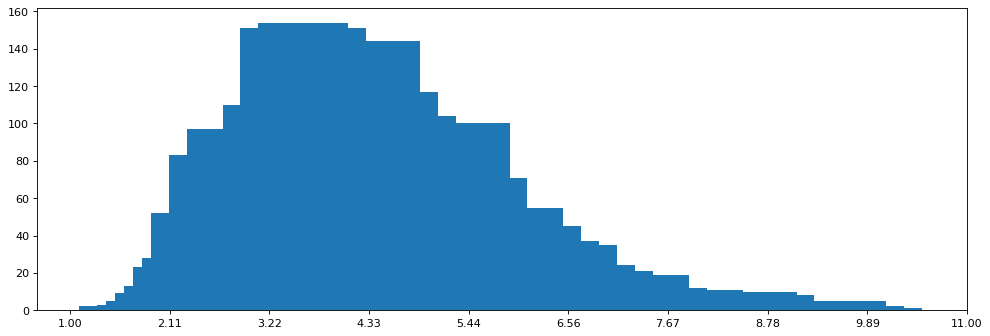

In [11]:
len_dict = audios.stats(prec=1)

`stats` will pass you back a dictionary with the file lengths, and file names, so that you may do with it what you want. 

One option is to call `get_outliers` which will return a sorted list of tuples containing the filename, and length of files that are more than `devs` (float) standard deviations from the mean length. This can be helpful for weeding out bad data. 

In [12]:
outliers = get_outliers(len_dict, devs=3)
print("Total Outliers:", len(outliers))
outliers[:10]

Total Outliers: 42


[(PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00201.wav'),
  8.72),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00134.wav'),
  8.72),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00352.wav'),
  8.72),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00141.wav'),
  8.72),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00216.wav'),
  8.76),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00313.wav'),
  8.76),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00288.wav'),
  8.76),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00345.wav'),
  8.76),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00110.wav'),
  8.8),
 (PosixPath('/root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00309.wav'),
  8.8)]

The `stats` method showed us that this dataset has only one sample rate. If you have multiple sample rates, you will need to resample to a single sample rate by setting `resample_to` in the configuration settings. If you want to do any customization, you'll need to pass a config object to the AudioList constructor, so before we go any further, here's how to use it.

## Audio Configuration

All config settings are managed through an `AudioConfig object`. It also contains within it a `SpectrogramConfig` object that holds settings related to spectrograms and MFCC (mel-frequency cepstral coefficients). The inner config can be changed just like the outer one by nesting. `config.sg_cfg.top_db=80` for instance

In [13]:
config = AudioConfig()
config

AudioConfig(cache=True, duration=None, max_to_pad=None, pad_mode='zeros', remove_silence=None, use_spectro=True, mfcc=False, delta=False, silence_padding=200, silence_threshold=20, segment_size=None, resample_to=None, standardize=False, downmix=False, sg_cfg=SpectrogramConfig(f_min=0, f_max=22050, hop=256, n_fft=2560, n_mels=128, pad=0, to_db_scale=True, top_db=100, ws=None, n_mfcc=20))

As you can see there are tons of features here, most of which you will not need to adjust to get pretty good results. If you plan on doing a lot of work on audio, or have a dataset with lots of silence, or a wide variety of audio lengths, check out our **Features Notebook** in the example folder, it shows when and how to adjust each of these settings.

For now we will only cover the most essential features `resample_to`, `max_to_pad` and `duration`

### `duration` and `max_to_pad`

Eventually, our audio will become spectrograms (visual representations of audio that can be passed to an image classifier). 
Like images, it is important that our spectrograms be the same size so that the GPU can handle them efficiently. Since audio clips rarely have precisely equal length, we give you two options for generating fixed width spectrograms. Which one is best for you will depend on the nature of your data. If your data varies in length by even a moderate amount, you will want to use `duration`.

1. Specify the `duration` setting of your config. This will compute the spectrogram using the entire clip regardless of length, but at train time will grab random sections that are `duration` milliseconds long. If duration is greater than the length of the clip, it will pad your spectrogram with zeroes to be the same length as the others. 

2. Set the `max_to_pad` attribute of your config (in milliseconds) to be the length you want your audio to be. This will pad or trim the underlying audio, and then generate spectrograms from that resulting audio. It will zero-pad clips that are too short, and trim clips that are too long, throwing away the remaining data. 

For this dataset, let's use duration so we don't throwaway data from the longer clips, and let's use 4000ms (4s). 

In [0]:
config.duration = 4000

### `resample_to`

Also it is important that all of the data is the same sample rate. If one spectrogram has a sample rate of 44100, and another's is 16000, the x-axis of the spectrogram will represent different amounts of time, and thus they won't be comparable. So if you see more than one sample rate when you call the `.stats()` method above, you will need to set `resample_to` to be an int representing the sample rate you wish to use. It is best practice to use common sample rates (44100, 22050, 16000 or 8000) as they will be faster to resample. 

For our data, there is no need to resample, but if we did, the code to downsample to 8000 would just be `config.resample_to=8000`

## Creating a databunch

Now we follow the normal fastai datablock API, making sure to pass our config to the AudioList

In [0]:
label_pattern = r'_([mf]\d+)_'
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

Fastai Audio performs on the fly data augmentation directly on spectrograms. Try uncommenting the second line and playing around with the transform manager and for more detail check out the Features Notebook

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00390.wav
Total Length: 4.68 seconds
Number of Channels: 1
Label: m0005
0.1s-4.1s of original clip


Channel 0.0 (128x250):


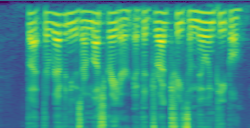

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00201.wav
Total Length: 4.48 seconds
Number of Channels: 1
Label: f0005
0.38s-4.38s of original clip


Channel 0.0 (128x250):


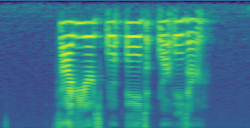

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00241.wav
Total Length: 5.4 seconds
Number of Channels: 1
Label: m0001
0.56s-4.56s of original clip


Channel 0.0 (128x250):


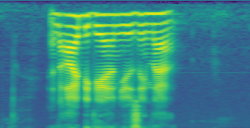

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00043.wav
Total Length: 5.2 seconds
Number of Channels: 1
Label: m0003
0.93s-4.93s of original clip


Channel 0.0 (128x250):


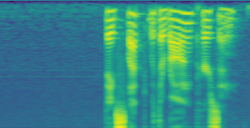

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00238.wav
Total Length: 2.68 seconds
Number of Channels: 1
Label: f0001


Channel 0.0 (128x250):


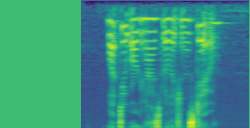

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00189.wav
Total Length: 5.88 seconds
Number of Channels: 1
Label: f0005
1.7s-5.7s of original clip


Channel 0.0 (128x250):


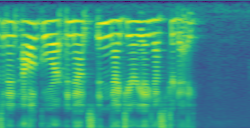

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00028.wav
Total Length: 4.04 seconds
Number of Channels: 1
Label: f0005
0.03s-4.03s of original clip


Channel 0.0 (128x250):


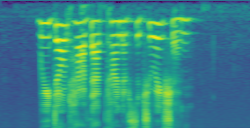

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00005.wav
Total Length: 4.88 seconds
Number of Channels: 1
Label: m0003
0.16s-4.16s of original clip


Channel 0.0 (128x250):


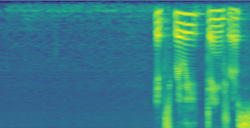

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00058.wav
Total Length: 4.92 seconds
Number of Channels: 1
Label: m0004
0.37s-4.37s of original clip


Channel 0.0 (128x250):


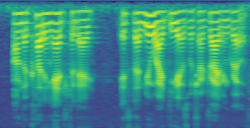

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00325.wav
Total Length: 2.0 seconds
Number of Channels: 1
Label: f0002


Channel 0.0 (128x250):


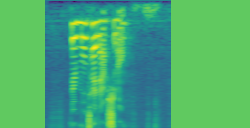

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00060.wav
Total Length: 3.56 seconds
Number of Channels: 1
Label: m0002


Channel 0.0 (128x250):


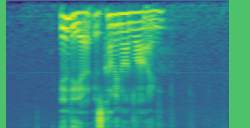

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00047.wav
Total Length: 2.84 seconds
Number of Channels: 1
Label: f0001


Channel 0.0 (128x250):


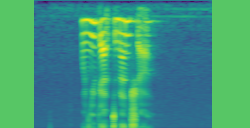

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00082.wav
Total Length: 5.04 seconds
Number of Channels: 1
Label: m0004
0.14s-4.14s of original clip


Channel 0.0 (128x250):


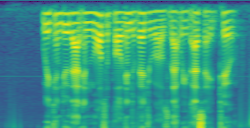

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00322.wav
Total Length: 4.8 seconds
Number of Channels: 1
Label: m0001
0.61s-4.61s of original clip


Channel 0.0 (128x250):


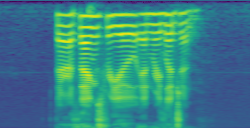

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00271.wav
Total Length: 3.4 seconds
Number of Channels: 1
Label: f0004


Channel 0.0 (128x250):


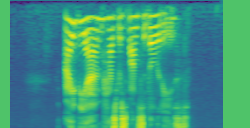

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0001_us_m0001_00062.wav
Total Length: 4.72 seconds
Number of Channels: 1
Label: m0001
0.54s-4.54s of original clip


Channel 0.0 (128x250):


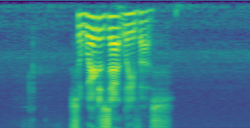

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00099.wav
Total Length: 3.0 seconds
Number of Channels: 1
Label: m0004


Channel 0.0 (128x250):


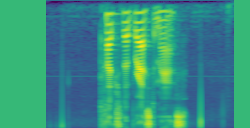

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00183.wav
Total Length: 4.8 seconds
Number of Channels: 1
Label: m0002
0.24s-4.24s of original clip


Channel 0.0 (128x250):


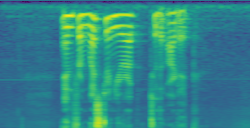

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00138.wav
Total Length: 3.12 seconds
Number of Channels: 1
Label: f0001


Channel 0.0 (128x250):


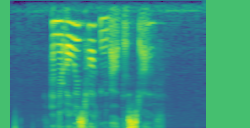

------------------------------------------------------------
File: /root/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00040.wav
Total Length: 4.96 seconds
Number of Channels: 1
Label: f0003
0.46s-4.46s of original clip


Channel 0.0 (128x250):


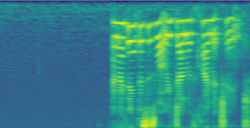

In [16]:
tfms = None
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
db = audios.transform(tfms).databunch(bs=64)
db.show_batch(20)

When audio is longer than the duration you've selected for training, it is clipped at random, but those items will tell you what time portion of the original audio clip the spectrogram and displayed audio represent. It will appear as '2.53s-6.53s of original clip'. Clips that are shorter than duration are padded with zeros, this will appear as a blue-green bar on the right hand side of the spectrogram

# Learner

An Audio learner takes a databunch, base_arch(optional, defaults to resnet18 for now), and metrics(optional, defaults to accuracy) and returns a cnn_learner. For now it is just a wrapper, but additional functionality is coming soon. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


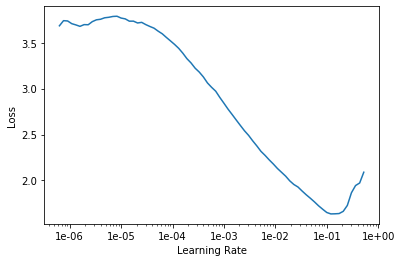

In [17]:
learn = audio_learner(db)
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))

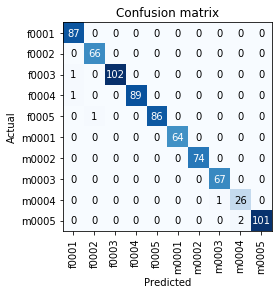

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Conclusion 

With 30 seconds of compute, and no preprocessing or fine tuning, you just created a voice-recognition system with 99% accuracy. 
But this is really just scratching the surface, so please check out our other notebooks in the examples folder and see what else is possible. 

# Acknowledgements
This library builds on the work of many others. It is of course built on top of fastai, so thank you to **Jeremy, Rachel, Stas, Sylvain** and countless others. It is a fork of https://github.com/zcaceres/fastai-audio and so we owe a lot to **@aamir7117 @marii @simonjhb @ste @ThomM @zachcaceres**. And it is built on top of torchaudio which helps us do things many things much faster than would otherwise be possible. Thanks as well to those who have been active in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123). 

Also we would love feedback, bug reports, feature requests, and whatever else you have to offer. We welcome contributors of all skill levels. If you need to get in touch for any reason, please post in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) or contact us via PM [@baz](https://forums.fast.ai/u/baz/) or [@madeupmasters](https://forums.fast.ai/u/MadeUpMasters/) Let's build an audio machine learning community!